<a href="https://colab.research.google.com/github/fjme95/python-para-la-ciencia-de-datos/blob/main/Semana%205/Clustering_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

En este notebook se implementaremos **K-Means** y usaremos la **gráfica de codo** para al selección óptima de K. 

Para ocupar k-means en el dataset que ocuparemos, es necesario vectorizar texto. Para esto, compararemos los resultados obtenidos con dos maneras distintas de vectorización: **TfIdf** y **GloVe**.

# Dependencias

## Librerias

Actualizamos plotly e instalamos wordcloud

In [ ]:
!pip install -U plotly wordcloud

     |████████████████████████████████| 25.3 MB 42 kB/s 
     |████████████████████████████████| 366 kB 72.5 MB/s 
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [ ]:
import pandas as pd
import numpy as np

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim.downloader as api

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Variables y configuración

In [ ]:
pio.templates.default = "plotly_white"

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Datos

Ocuparemos los datos de la [Australian Food Composition Database](https://www.foodstandards.gov.au/science/monitoringnutrients/afcd/Pages/default.aspx) que contiene datos sobre los nutrientes de comida comumente consumida en Australia. Nuestro objetivo es agrupar los nombres de los alimentos usando K-Means.

In [ ]:
%load_ext google.colab.data_table
data = pd.read_excel('https://www.foodstandards.gov.au/science/monitoringnutrients/afcd/Documents/Release%201%20-%20Food%20details%20file.xlsx', usecols=['Name', 'Description'])
data

Name                                        Description
0                          Cardamom seed, dried, ground  Ground spice commonly used in Indian cooking a...
1                         Chilli (chili), dried, ground  Dried and ground red pepper, characterised by ...
2                               Cinnamon, dried, ground  Dried and ground bark or quills of Cinnamomum ...
3                                 Cloves, dried, ground  Dried and ground, unopened flower buds of Syzy...
4                         Coriander seed, dried, ground  Dried and ground fruit or seed of Coriandrum s...
...                                                 ...                                                ...
1529  Zucchini, green skin, fresh, unpeeled, fried, ...  A variety of summer squash, picked when small....
1530  Zucchini, green skin, fresh, unpeeled, boiled,...  Variety of marrow or summer squash, picked whe...
1531             Zucchini, golden, fresh, unpeeled, raw  Variety of squash which has a yellow smooth sk...
1532  Zucchini, golden, fresh, unpeeled, fried, no a...  Variety of squash which has a yellow smooth sk...
1533  Zucchini, golden, fresh, unpeeled, boiled, dra...  Variety of squash which has a yellow smooth sk...

[1534 rows x 2 columns]

## Exploración

In [ ]:
# https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5

def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");

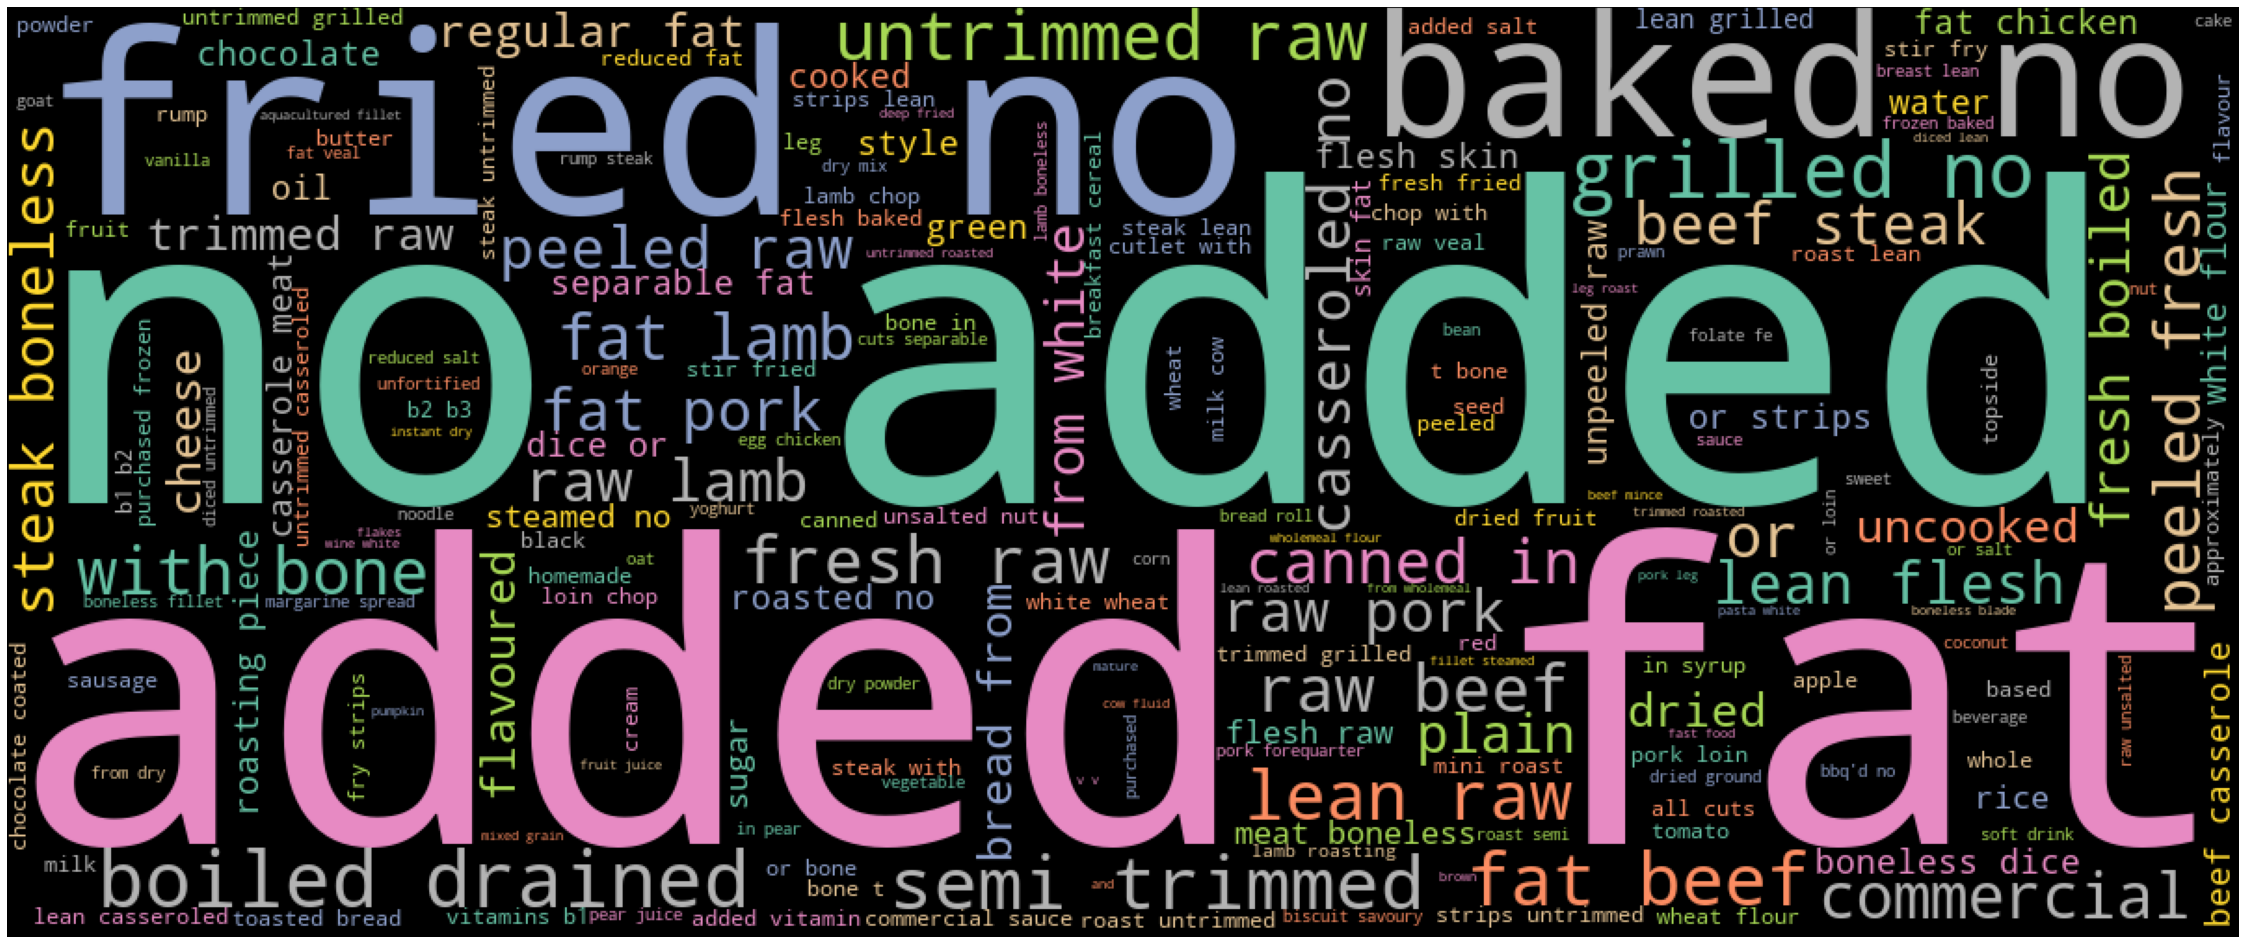

In [ ]:
wordcloud = WordCloud(width= 1200, height = 500, colormap='Set2', random_state=1, stopwords = []).generate(data.Name.str.cat(sep = ', ').lower())# Plot
plot_cloud(wordcloud)

In [ ]:
stopwords_list = ['added', 'green', 'white', 'rose', 'added']

# Vectorización - GloVe

Cargamos el modelo preentrenado [```glove-wiki-gigaword-300```](https://nlp.stanford.edu/projects/glove/), este tiene 400,000 palabras con vectores de dimensión 300. Fue entrenado ocupando Wikipedia 2014 y [Gigaword 5](https://catalog.ldc.upenn.edu/LDC2011T07).

In [ ]:
word_vectors = api.load("glove-wiki-gigaword-300") 

[==================================================] 100.0% 376.1/376.1MB downloaded


Se crea la función para poder tokenizar los nombres de los alimentos.

In [ ]:
def tokenize(text, lemmatize = True):
    # return [stemmer.stem(word) for word in word_tokenize(text.lower()) if len(word) > 2 and word not in stopwords_list]
    if lemmatize:
        return  [lemmatizer.lemmatize(word) for word in word_tokenize(text.lower()) if len(word) > 2 and word not in stopwords_list]
    return  [word for word in word_tokenize(text.lower()) if len(word) > 2 and word not in stopwords_list]

In [ ]:
print(data.Name[0])
tokenize(data.Name[0])

Cardamom seed, dried, ground


['cardamom', 'seed', 'dried', 'ground']

In [ ]:
# word_vectors.get_vector('cardamom')

Aquí hay tres posibilidades de tokenizar el texto:
1. Tokeniza todo el nombre y el vector del documento es la media de la representación vectorial de cada token (palabra).
2. Tokeniza todo el nombre sin lematizar y el vector del documento es la suma de la representación vectorial de cada token (palabra).
3. Tokeniza sólo la primera palabra en el nombre

Todas van a dar diferentes resultados al momento de ejecutar K-Means y es bueno explorarlas dependiendo del objetivo final.

In [ ]:
# tokens = [np.mean([word_vectors.get_vector(word) for word in tokenize(name) if word not in stopwords_list and word in word_vectors.vocab], axis = 0) for name in data.Name]
tokens = [np.sum([word_vectors.get_vector(word) if word in word_vectors.vocab else np.repeat(0, 300) for word in tokenize(name, False) if word not in stopwords_list], axis = 0) for name in data.Name]
# tokens = [word_vectors.get_vector(word) if word in word_vectors.vocab else np.repeat(0, 300) for name in data.Name for word in [tokenize(name, False)[0]] if word not in stopwords_list]

Revisamos si hubo algún documento cuya representación vectorial sean 300 ceros.

In [ ]:
for i in range(len(tokens)):
    if np.all(tokens[i]) == False:
        print(data.Name[i])

In [ ]:
# 'Morwong' in word_vectors.vocab

Convertimos la lista a un ```numpy.array```

In [ ]:
X = np.array(tokens)
X.shape

(1534, 300)

## Agrupación (Clustering)

In [ ]:
n_clusters = 50
clusterer = KMeans(n_clusters=n_clusters, random_state = 10).fit(X)
clusters = clusterer.predict(X)

In [ ]:
pd.DataFrame(np.unique(clusters, return_counts=True), index = ['cluter', 'count']).T.sort_values('count').iloc[::-1, :]

cluter  count
17      17    122
39      39     99
10      10     85
25      25     72
30      30     63
12      12     59
40      40     54
21      21     48
4        4     45
28      28     45
20      20     39
29      29     39
13      13     37
18      18     36
22      22     36
1        1     34
2        2     33
24      24     33
37      37     31
15      15     30
11      11     29
49      49     29
5        5     28
48      48     27
43      43     23
0        0     22
26      26     22
23      23     21
9        9     21
46      46     20
19      19     20
6        6     19
36      36     18
31      31     17
33      33     17
3        3     16
42      42     16
35      35     15
41      41     14
16      16     13
45      45     12
32      32     12
38      38     11
14      14     10
8        8      9
7        7      9
27      27      9
44      44      7
34      34      6
47      47      2

In [ ]:
X_df = data.copy()
X_df['cluster'] = clusters
X_df

Name  ... cluster
0                          Cardamom seed, dried, ground  ...      40
1                         Chilli (chili), dried, ground  ...      40
2                               Cinnamon, dried, ground  ...      40
3                                 Cloves, dried, ground  ...      40
4                         Coriander seed, dried, ground  ...      40
...                                                 ...  ...     ...
1529  Zucchini, green skin, fresh, unpeeled, fried, ...  ...      20
1530  Zucchini, green skin, fresh, unpeeled, boiled,...  ...      20
1531             Zucchini, golden, fresh, unpeeled, raw  ...      10
1532  Zucchini, golden, fresh, unpeeled, fried, no a...  ...      20
1533  Zucchini, golden, fresh, unpeeled, boiled, dra...  ...      25

[1534 rows x 3 columns]

In [ ]:
X_df[X_df.cluster == 17]

Name  ... cluster
19                     Salt, table, iodised  ...      17
20                 Salt, table, non-iodised  ...      17
22         Taco seasoning mix, chilli-based  ...      17
26                      Gelatine, all types  ...      17
28                           Starch, potato  ...      17
...                                     ...  ...     ...
1304                 Lolly, jelly varieties  ...      17
1306     Meringue, all flavours, commercial  ...      17
1403  Gherkin, pickled, drained, commercial  ...      17
1510                  Tamarind, paste, pure  ...      17
1519                       Tomato, sundried  ...      17

[122 rows x 3 columns]

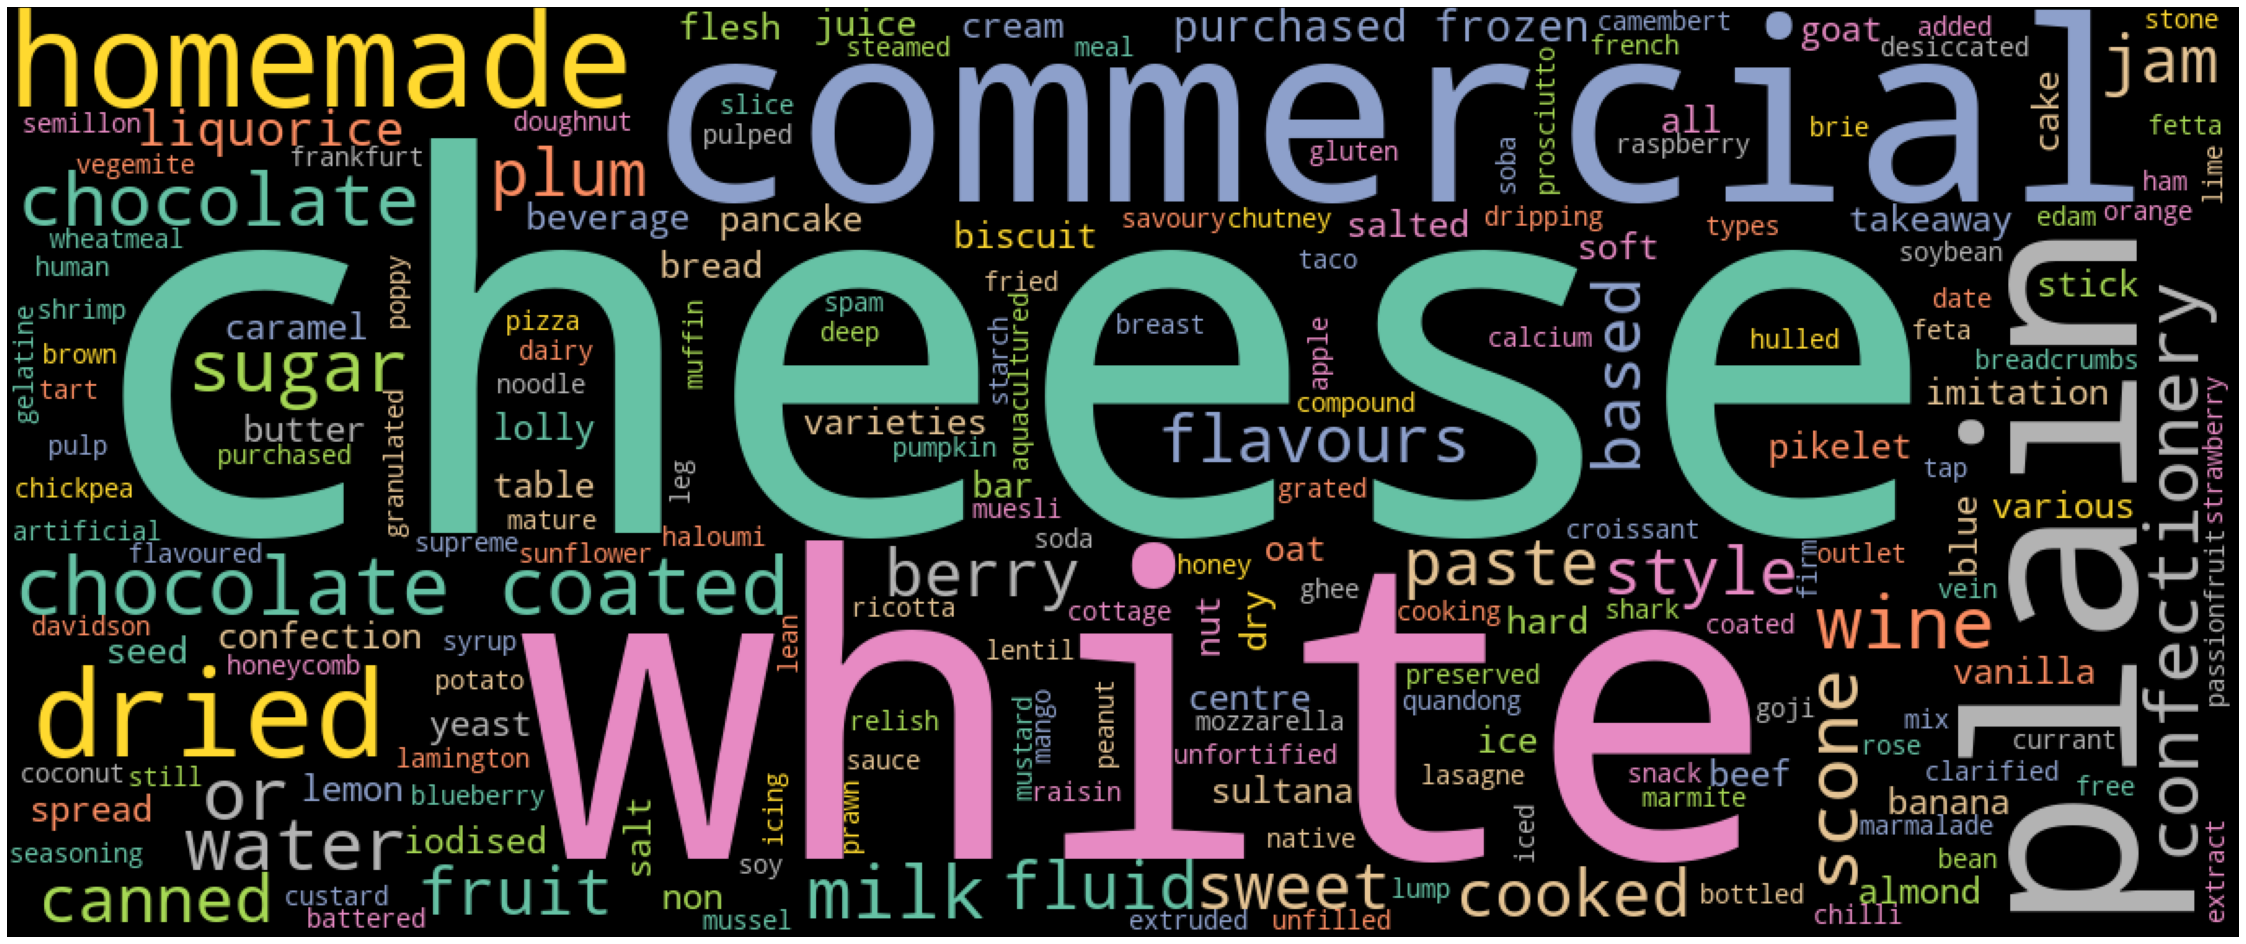

In [ ]:
# Import package
wordcloud = WordCloud(width= 1200, height = 500, colormap='Set2', random_state=1, stopwords = ['from', 'with']).generate(X_df[X_df.cluster == 17].Name.str.cat(sep = ', ').lower())# Plot
plot_cloud(wordcloud)

In [ ]:
from skimage import io

In [ ]:
img = io.imread('http://clipart-library.com/images_k/beef-cattle-silhouette/beef-cattle-silhouette-18.png')
img.shape

(893, 1290, 4)

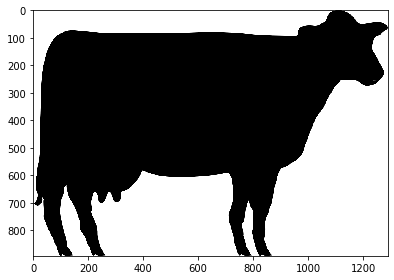

In [ ]:
io.imshow(img)

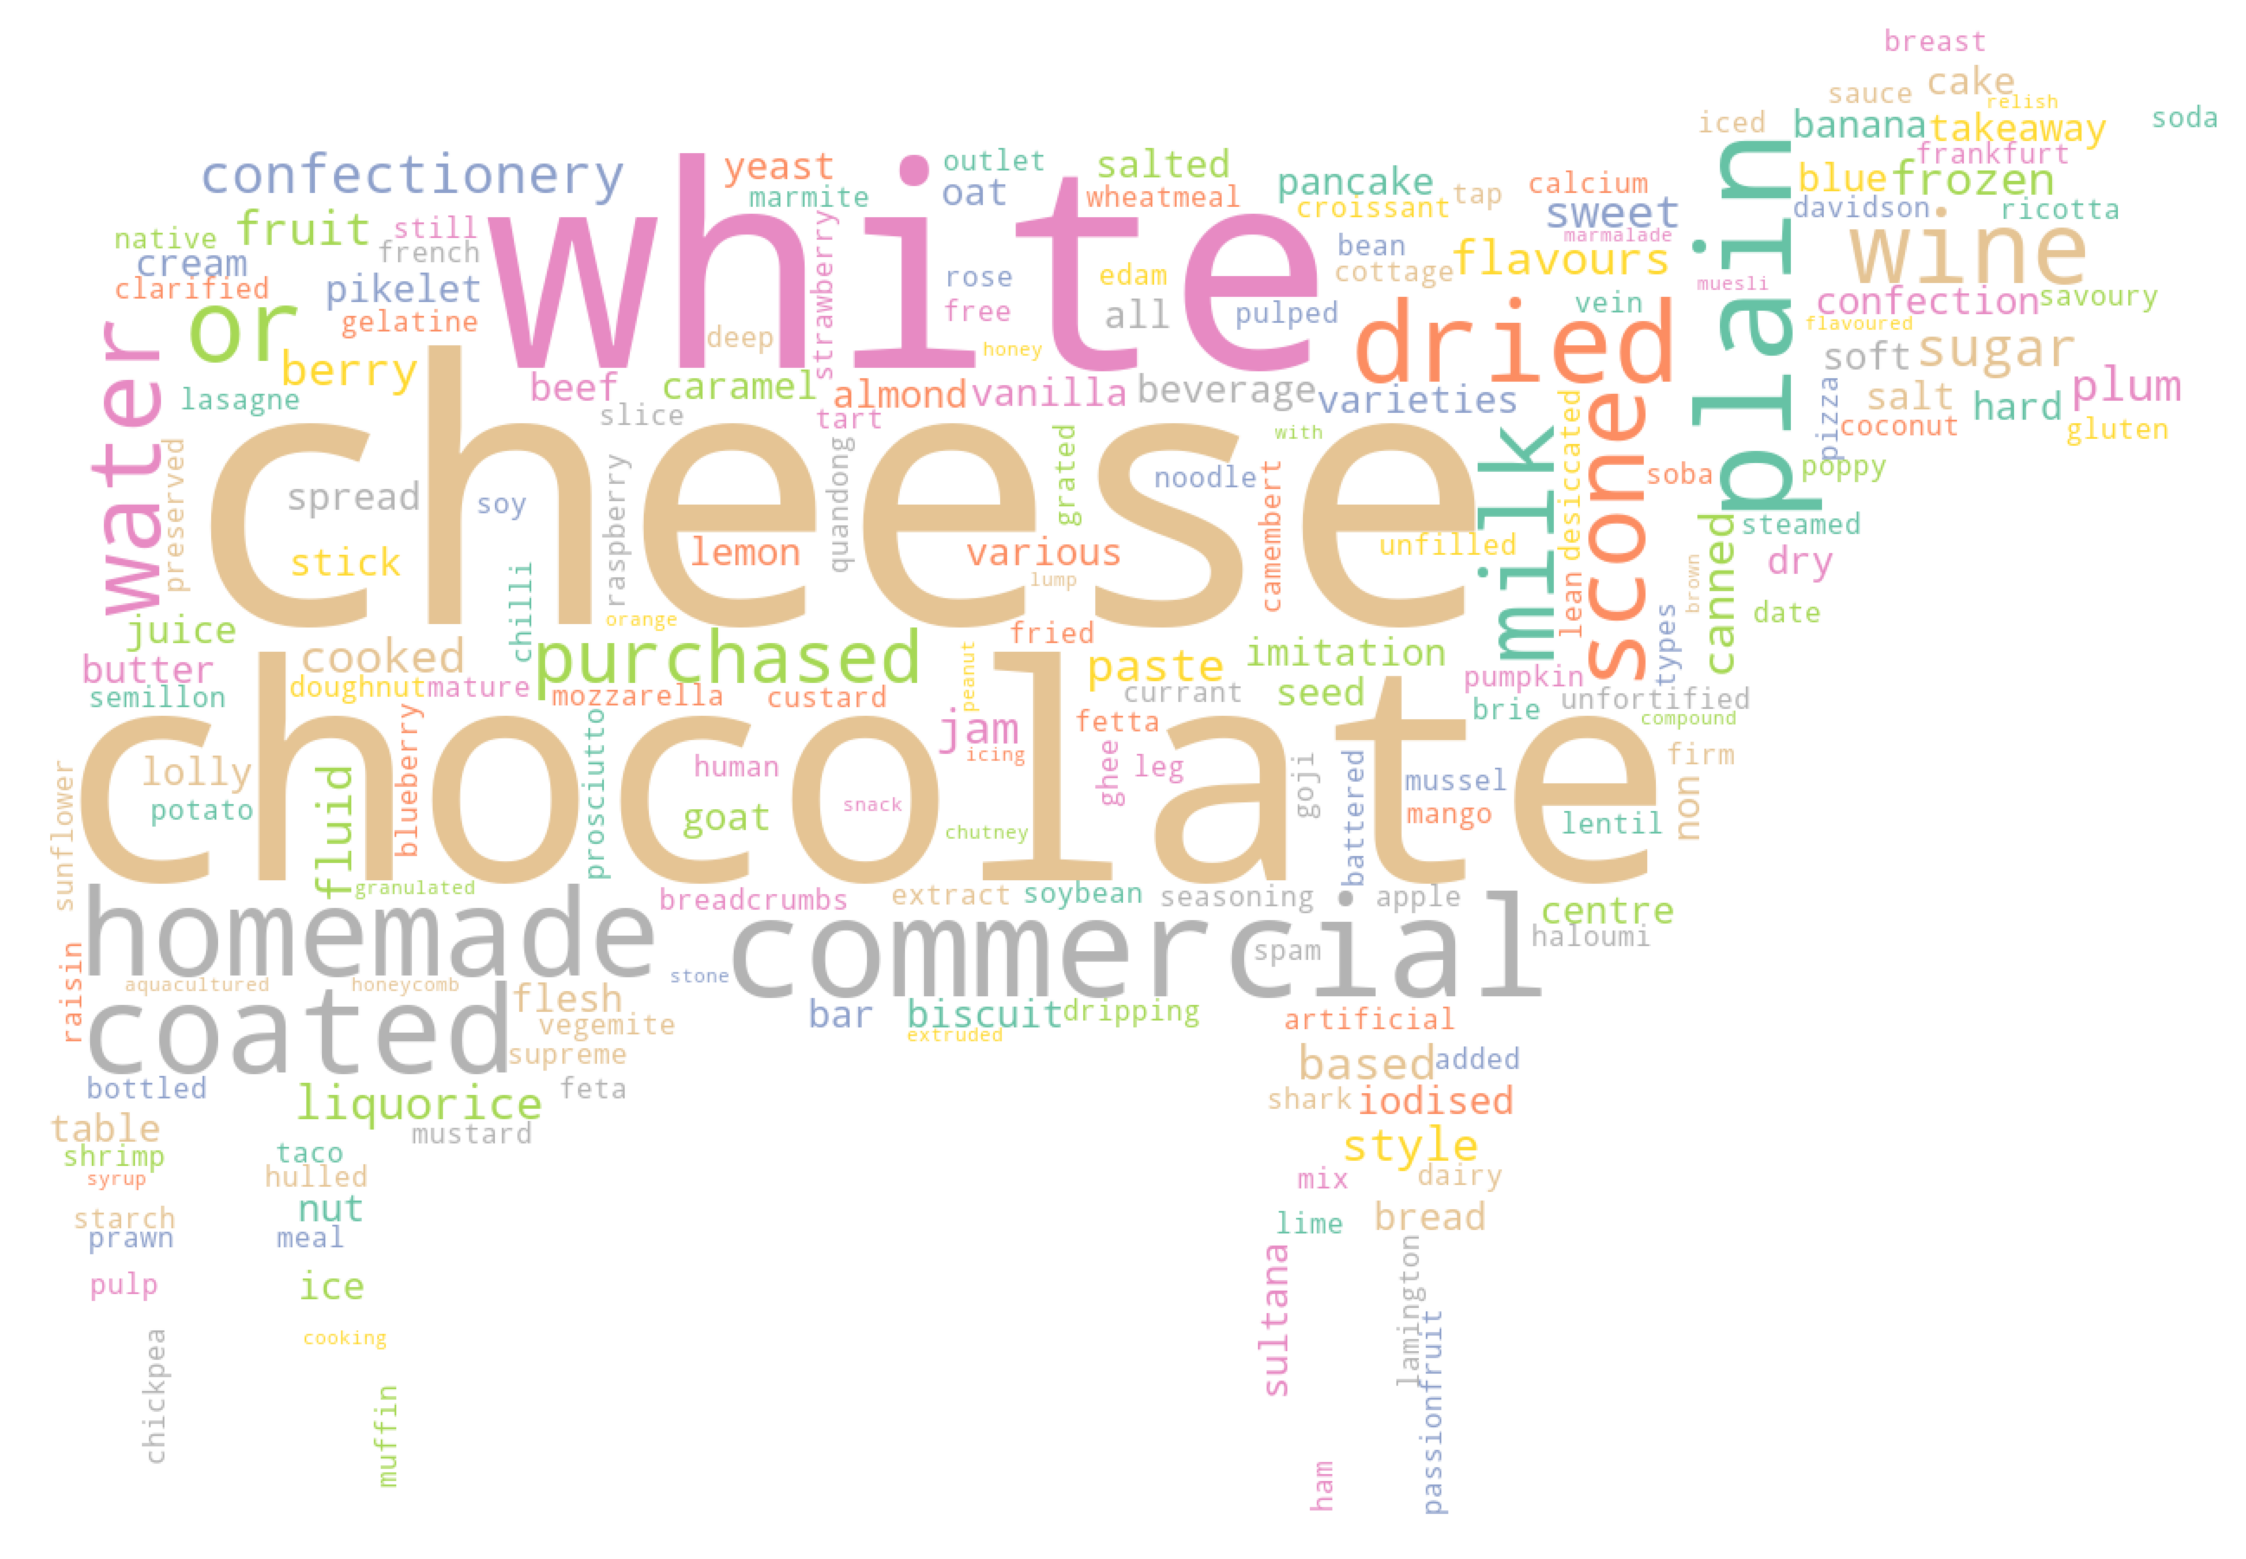

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500, random_state=1, background_color='white', colormap='Set2', collocations=False, mask=img, stopwords=[]).generate(X_df[X_df.cluster == 17].Name.str.cat(sep = ', ').lower())
plot_cloud(wordcloud)

## Selección de K óptima

Para ver qué K elegir vamos a revisar dos técnicas. 

La primera es la **gráfica de codo** que nos indica a partir de qué momento no hay mucha *ganancia* al incrementar el número de grupos creados. 

La segunda es el **análisis de silueta**. Nos ayuda a ver la cantidad de elementos en cada grupo y su **puntuación de silueta** (Silhouette score).

### Gráfica de codo (Scree plot)

Para obtener la gráfica de codo tenemos que ajustar el modelo a los datos para cada valor de K que queramos probar.

En [```sklearn.cluster.KMeans```](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html), el atributo ```inertia_``` nos da la suma de distancias al cuadrado entre las muestras y el centro del grupo más cercano. Este valor es el que ocupamos para la gráfica. Además, [```sklearn.metrics.silhouette_score```](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) nos da el score de silueta promedio para la selección de K. En este momento sólo ocuparemos la puntuación de silueta como métrica para ver qué tan bien se hacen las separaciones, en la siguiente sección haremos un análisis de silueta.

In [ ]:
sse = []
sil_score = []
clusters_list = range(2, 300, 10)

for i, k in enumerate(clusters_list):
    print(k, end = ', ')
    model = KMeans(n_clusters = k).fit(X)
    sse.append(model.inertia_)
    sil_score.append(silhouette_score(X, model.predict(X)))

2, 12, 22, 32, 42, 52, 62, 72, 82, 92, 102, 112, 122, 132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252, 262, 272, 282, 292, 


Ahora graficamos los valores obtenidos.

In [ ]:
px.line(
    x = clusters_list, 
    y = sse, 
    title = 'Scree Plot', 
    labels = {
        'x': 'Número de grupos (K)', 
        'y': 'Inercia<br>(MSE intra-grupos)'
        }
    )

Basándonos en la gráfica, el número de grupos óptimo esta alrededor de 22 o 32. Para estar más seguros, podemos volver a hacer la gráfica y tomar K en entre 20 y 35 con incrementos de uno para visualizar en dónde se encuentra el codo.

In [ ]:
px.line(
     x = clusters_list, 
     y = sil_score, 
     title = 'Silhouette score', 
     labels = {
         'x': 'Número de grupos (K)', 
         'y': 'Puntuación media de la silueta'
         }
     )

De momento sólo observaremos que la puntuación de silueta aumenta conforme el número de grupos aumenta. 

Además, cuando ```K = 2```, la puntuación de silueta es relativamente grande, esto es bueno. Sin embargo, si observamos la Scree plot en el mismo valor, también observamos un valor grande (*malo*). Lo que podemos concluir para este valor, es que hace una separación decente de los grupos, pero las muestras están muy separadas del centro.

Finalmente, el que la puntuación de silueta haya bajado para ```K=12```, nos indica que encontró grupos cuya separación no es muy grande entre los grupos cercanos a estos.

### Análisis de silueta

Para el análisis de silueta tenemos que calcular la puntuación de silueta para cada muestra en los datos y graficarlos. 

La puntuación de silueta va de ```-1``` a ```1```. ```1``` quiere decir que nuestros grupos están *compactos* y alejados de los otros grupos, ```-1``` que no hay distinción entre los grupos.

Lo ideal es que los grupos tengan una puntuación promedio de silueta alta y que la mayoría de la puntuación de las muestras esté por arriba del promedio para todos los grupos. También, no debería haber valores cercanos a cero o negativos pues indicaría que hay grupos "juntos", lo que provocaría una mala asignación a la muestra.

For n_clusters = 15 The average silhouette_score is : 0.08341537611364377
For n_clusters = 16 The average silhouette_score is : 0.08587412607352445
For n_clusters = 17 The average silhouette_score is : 0.0782474433883902
For n_clusters = 18 The average silhouette_score is : 0.07768595402155118
For n_clusters = 19 The average silhouette_score is : 0.09109745250861868
For n_clusters = 20 The average silhouette_score is : 0.08790351312717921
For n_clusters = 21 The average silhouette_score is : 0.08855973576727423
For n_clusters = 22 The average silhouette_score is : 0.08129026941254372
For n_clusters = 23 The average silhouette_score is : 0.08874819404051074
For n_clusters = 24 The average silhouette_score is : 0.09101789653916709
For n_clusters = 25 The average silhouette_score is : 0.09203468348676744
For n_clusters = 26 The average silhouette_score is : 0.09430897430368686
For n_clusters = 27 The average silhouette_score is : 0.09609547827041837
For n_clusters = 28 The average silhoue

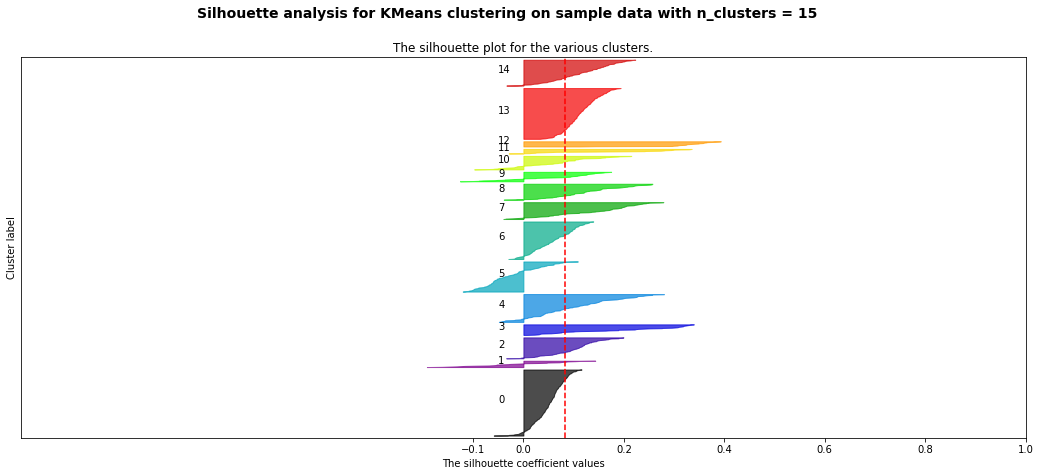

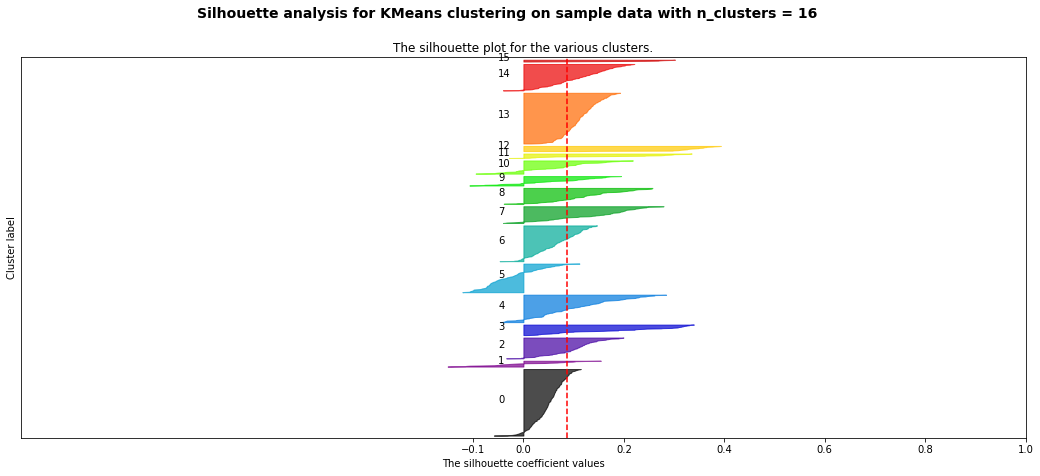

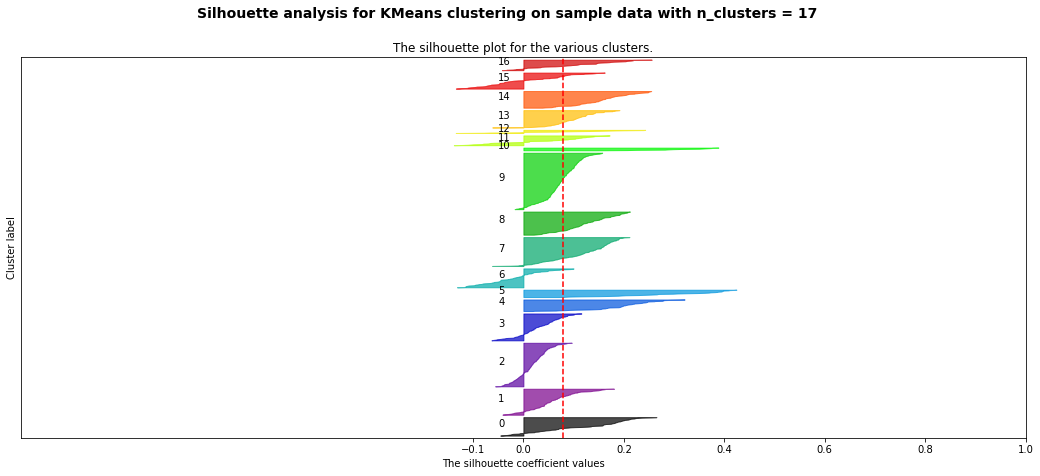

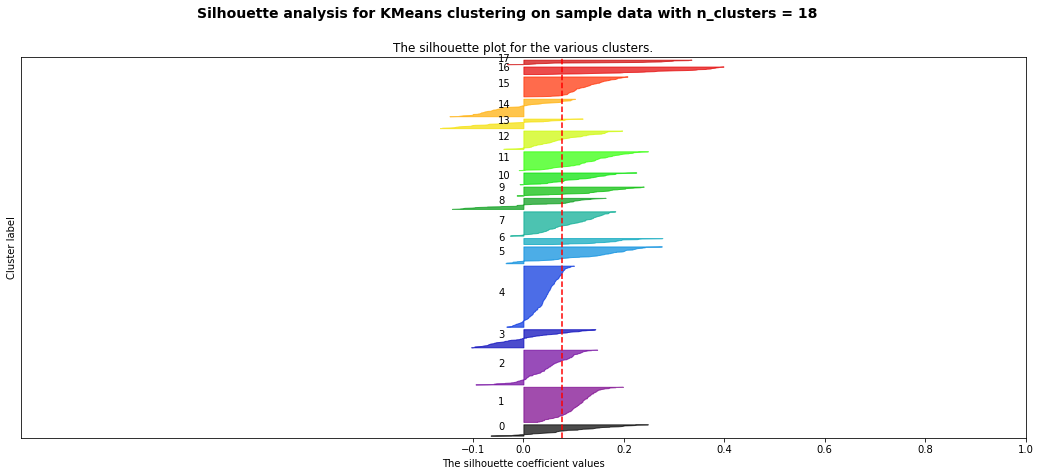

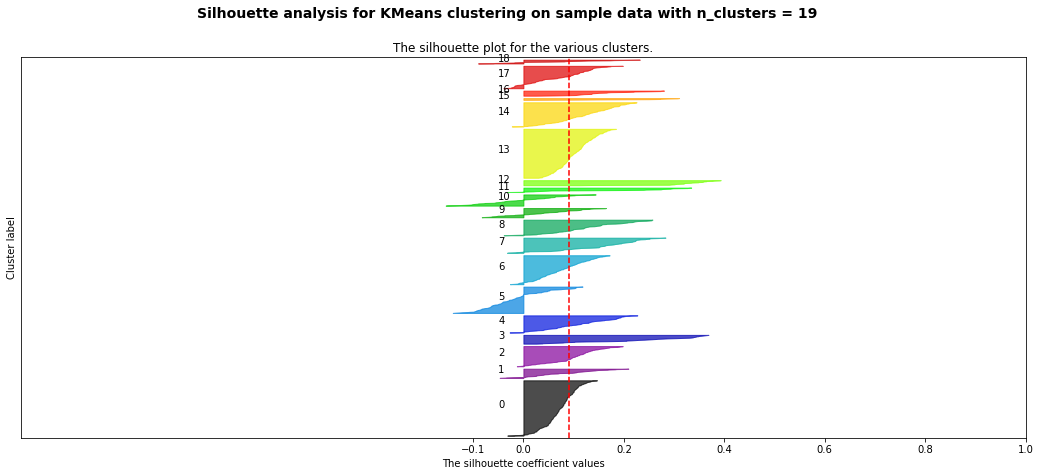

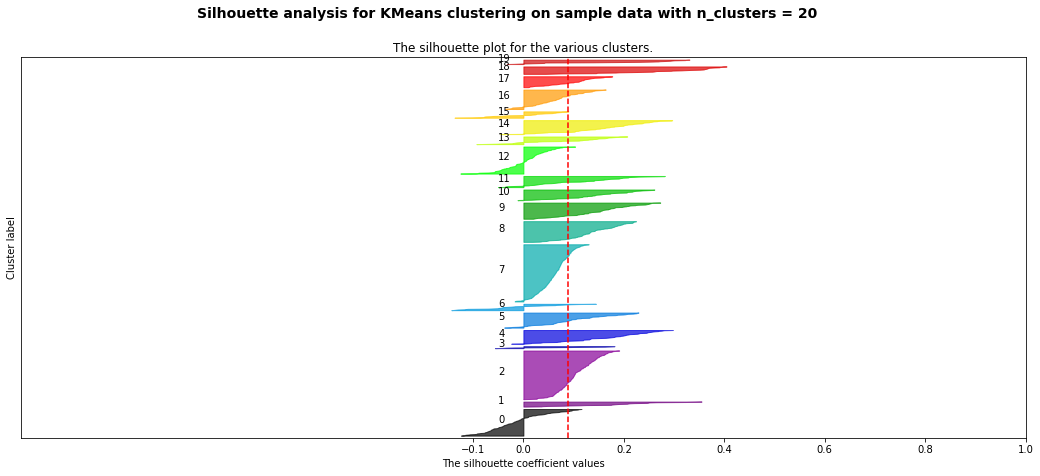

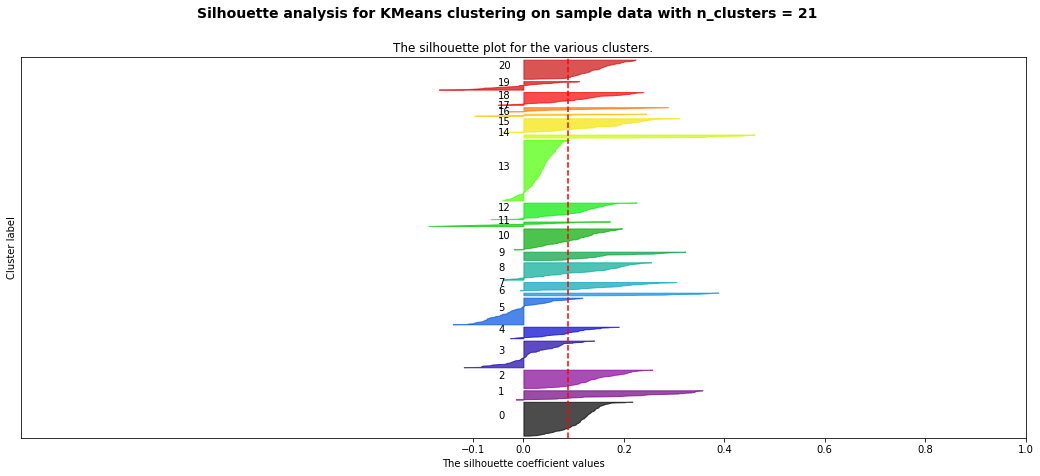

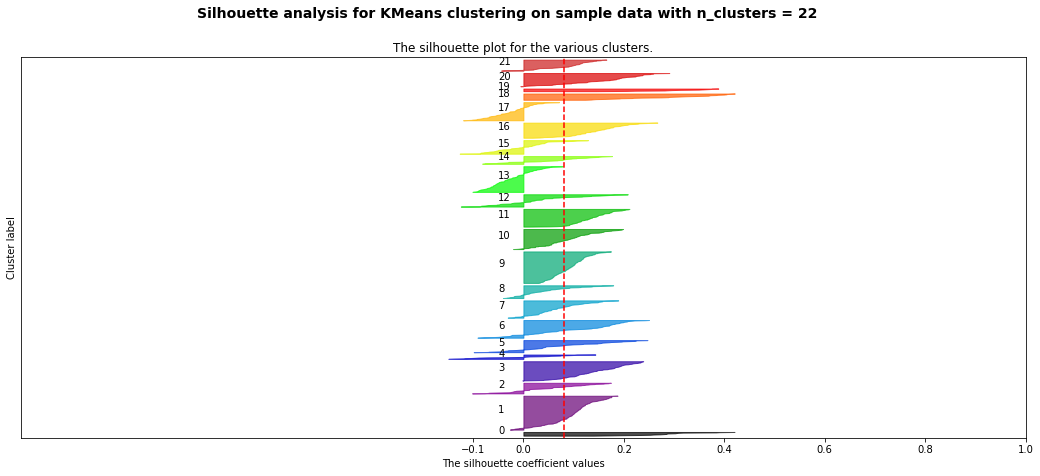

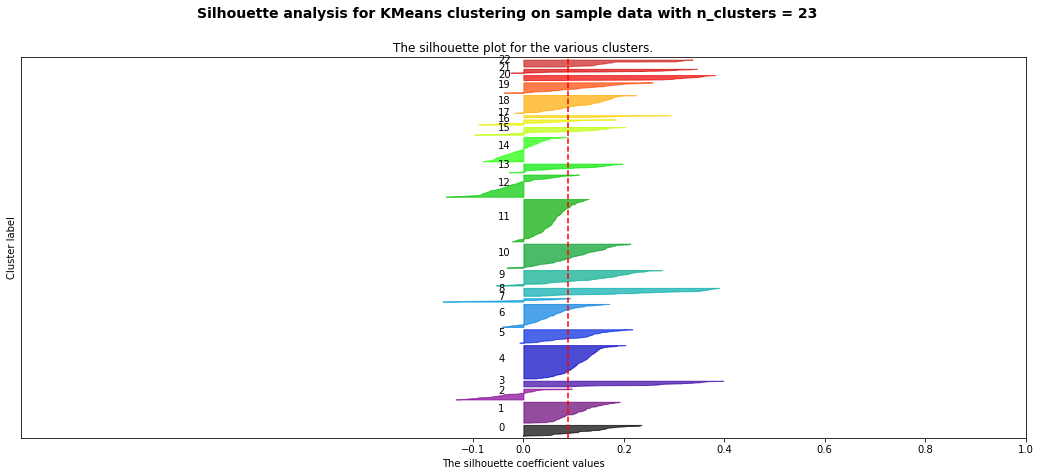

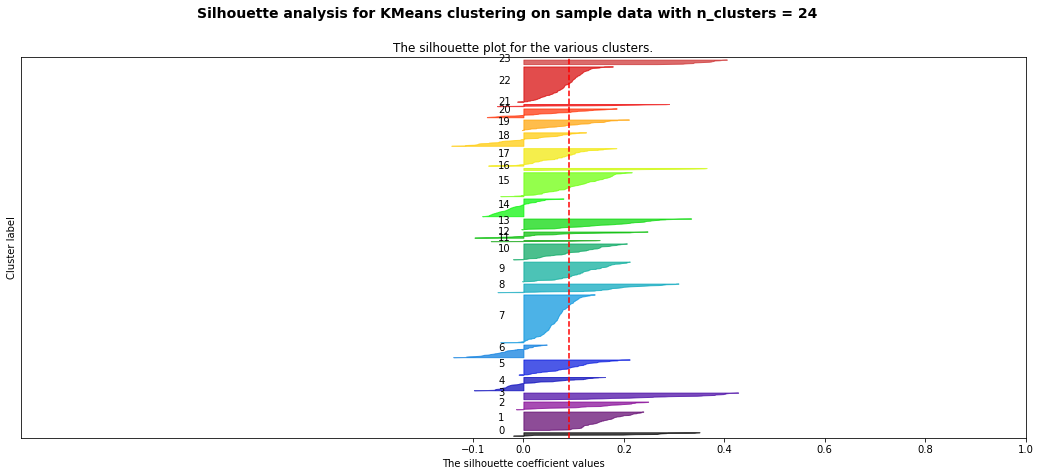

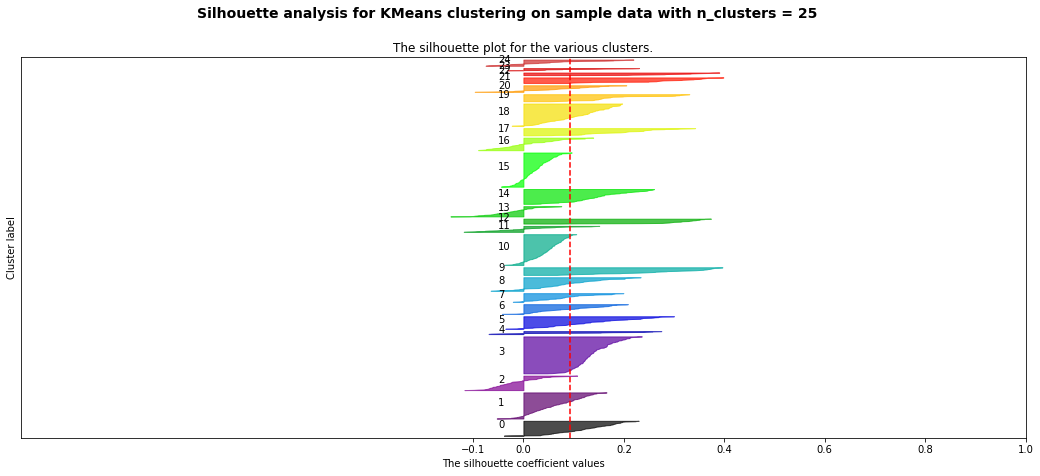

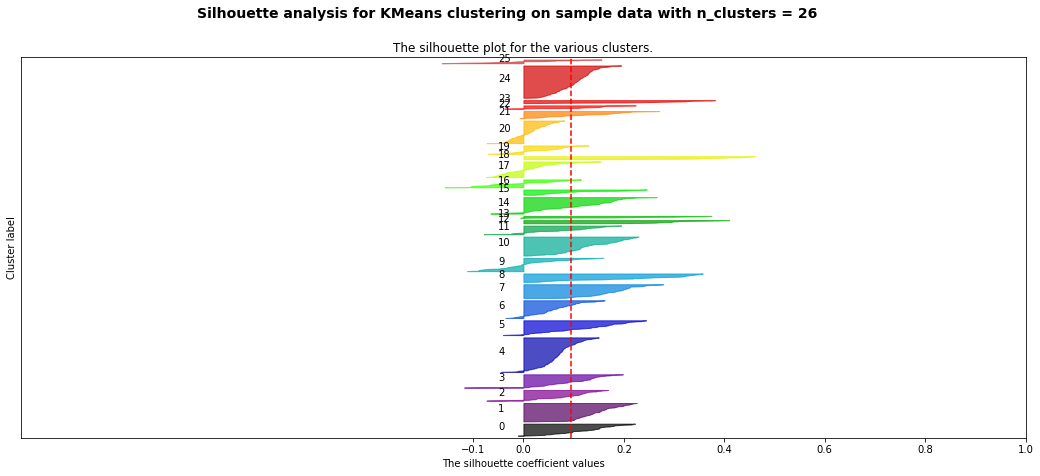

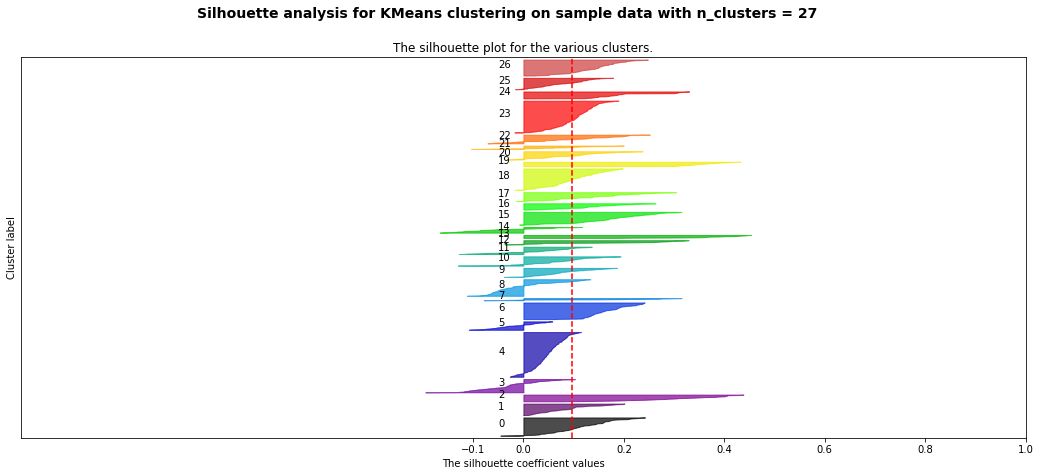

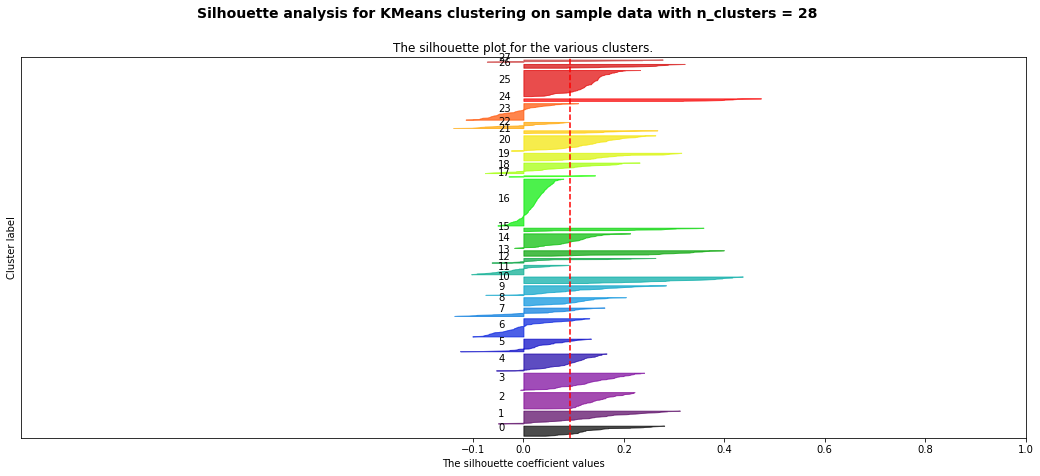

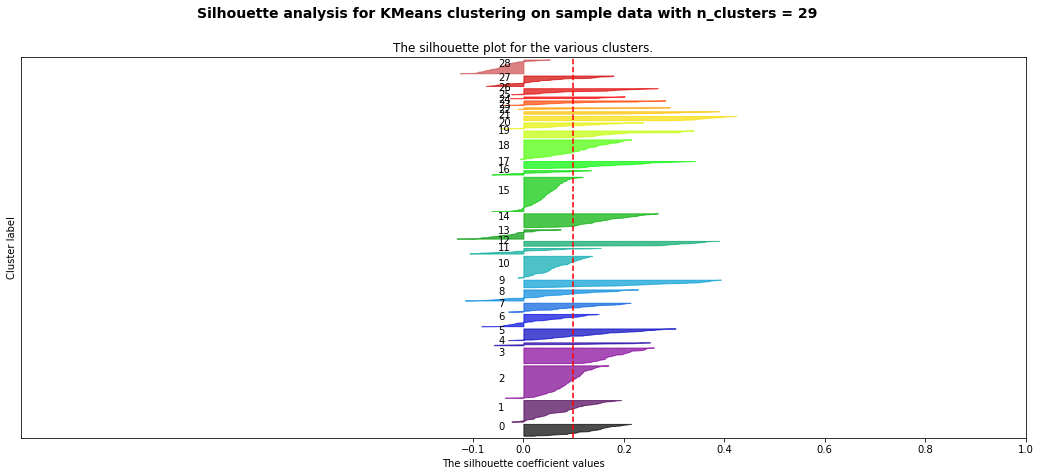

In [ ]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
range_n_clusters = range(15, 30)

for n_clusters in range_n_clusters:
    # Creamos un subplot. En el ejemplo hay dos gráficas, por eso tiene más sentido
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # Establecemos el límite para x en [-1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Observamos lo siguiente:
-  La puntuación de silueta promedio más grande fue para ```K=29```. Analicemos su gráfica.
    - La mayoría de los grupos están por encima del promedio (linea vertical roja). Sólo el grupo 28 y 13 no pasaron el promedio.
    - Hay grupos con muchas muestras que no pasaron la media como el 15 o el 11.
    - Hay muestras con valores negativos, lo que nos indica que hay grupo sin una separación clara.
    - El grupo 3 fue de los mejores.
    - Hay grupos con muy pocos elementos.
- Para ```K = 22```:
    - Hay una buena cantidad de grupos que pasaron la media
    - Los grupos 13, 15 y 17 son los menos *separados*.
    - Hay grupos con muy pocos elementos como el 4 o el 12.

Podemos seleccionar 22 o 29 grupos si nos guiamos con el análisis de silueta. 

### Modelo

In [ ]:
n_clusters = 22
clusterer = KMeans(n_clusters=n_clusters, random_state = 10).fit(X)
clusters = clusterer.predict(X)

In [ ]:
X_df = data.copy()
X_df['cluster'] = clusters
X_df

In [ ]:
X_df[X_df.cluster == 16]

Name  ... cluster
223          Pudding, plum, steamed or boiled, homemade  ...      16
304                       Noodle, soba, boiled, drained  ...      16
305               Noodle, wheat, fresh, soaked, drained  ...      16
307   Noodle, wheat, instant, flavoured, boiled, dra...  ...      16
308   Noodle, wheat, instant, flavoured, boiled, und...  ...      16
...                                                 ...  ...     ...
1502             Squash, button, fresh, boiled, drained  ...      16
1504         Squash, scallopini, fresh, boiled, drained  ...      16
1506              Swede, peeled, fresh, boiled, drained  ...      16
1512               Taro, peeled, fresh, boiled, drained  ...      16
1525            Water chestnut, peeled, canned, drained  ...      16

[71 rows x 3 columns]

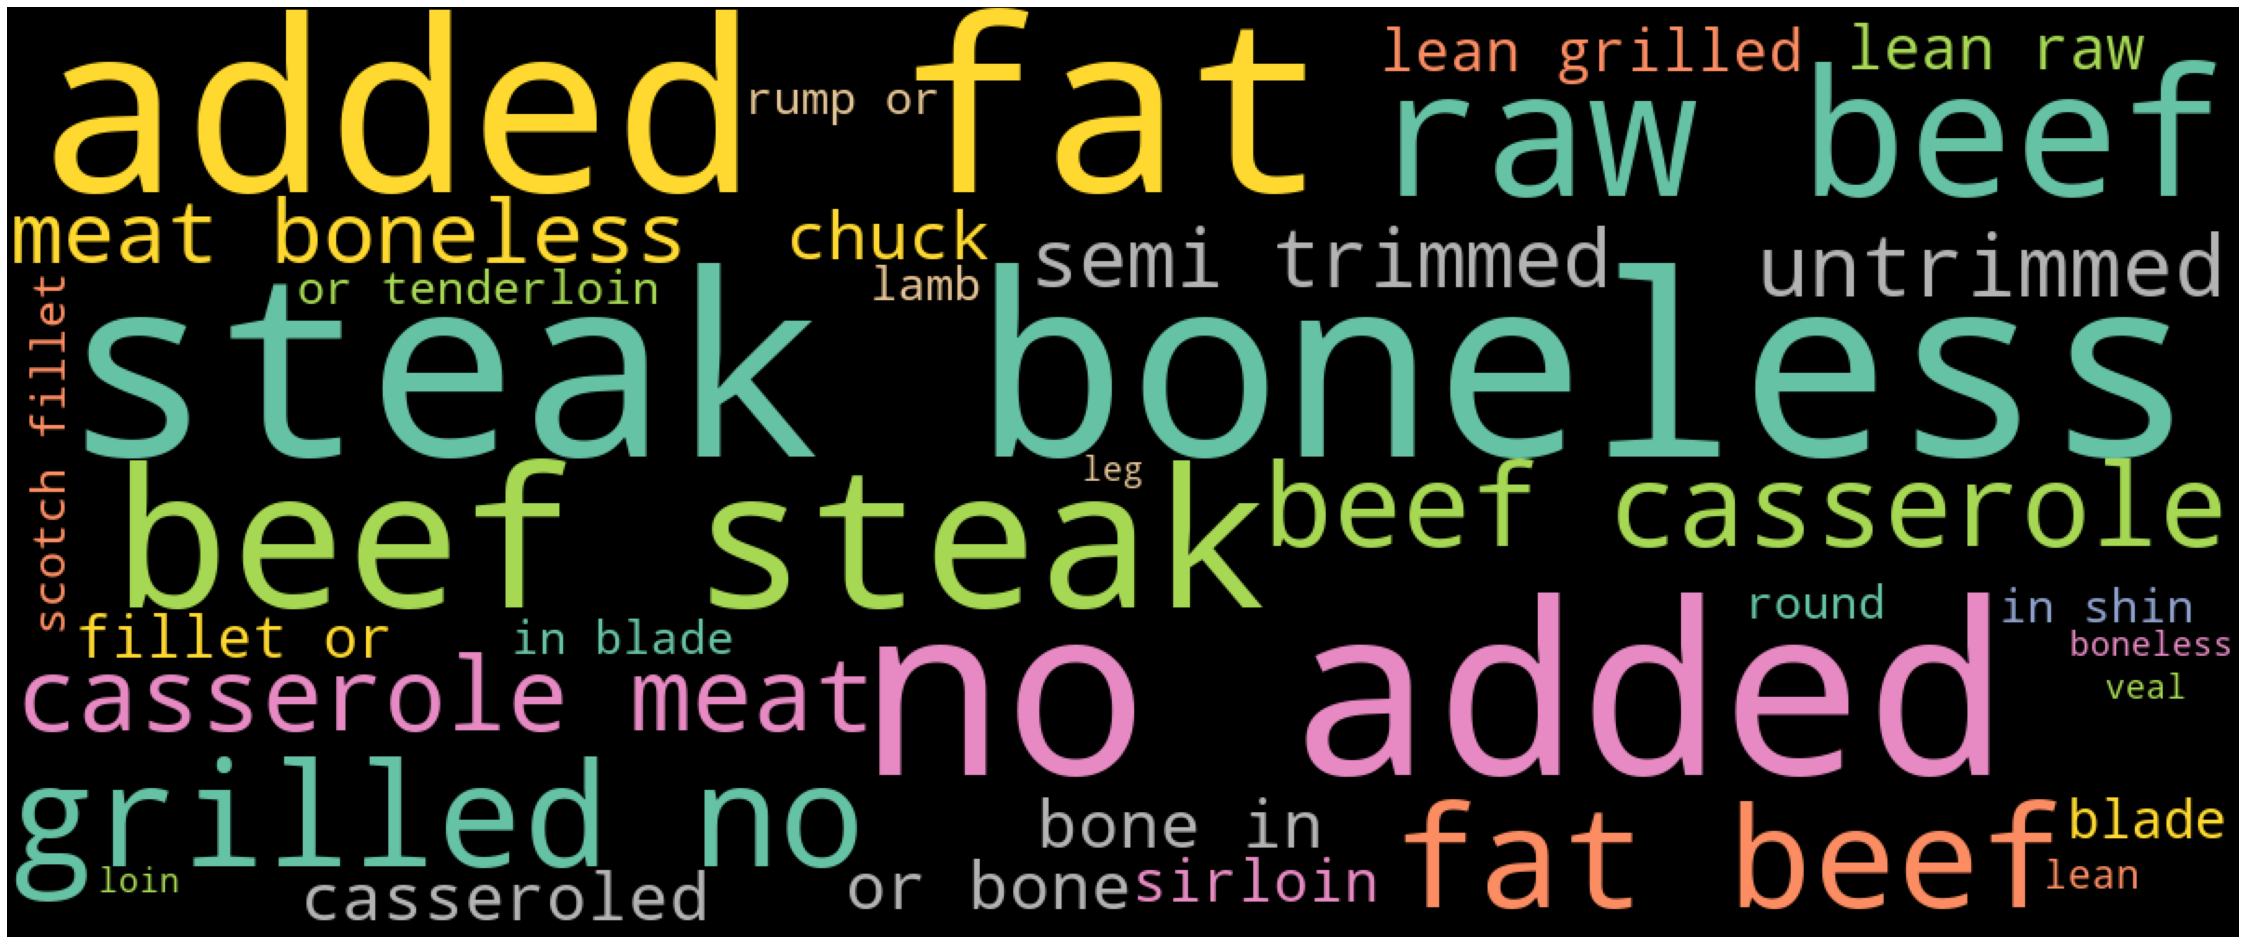

In [ ]:
# Import package
wordcloud = WordCloud(width= 1200, height = 500, colormap='Set2', random_state=1, stopwords = ['from', 'with']).generate(X_df[X_df.cluster == 20].Name.str.cat(sep = ', ').lower())# Plot
plot_cloud(wordcloud)

Revisando el tipo de alimentos que hay en cada grupo, podemos crear una etiqueta que podamos leer. Por ejemplo, 

- El grupo 0 es el de carne de cordero
- El 3 es el de carnes crudas, que también incluyen cordero. Por esta razón, podemos etiquetar ambos con "carne", por ejemplo.
- El 16 de vegetales y cosas "escurridas" y hervidas.
- El 20 carne sin hueso.
- etc.

Esta revisión nos permite ver posibles palabras que afectan al agrupamiento que estábamos esperando. Por ejemplo, podríamos agregar a las stopwords las palabras "added" y "drained" para ver si así el salmón ya no aparece en el grupo 16. 

Otra cosa que podemos hacer es aumentar el número de grupos que queremos que encuentre el algoritmo y posteriormente juntar a varios grupos con una sola etiqueta.

# Vectorización - TfIdf

In [ ]:
vect = TfidfVectorizer(tokenizer=tokenize)
X = vect.fit_transform(data.Name)
X

<1534x919 sparse matrix of type '<class 'numpy.float64'>'
	with 7723 stored elements in Compressed Sparse Row format>

In [ ]:
sse = []
sil_score = []
clusters_list = range(2, 300, 10)
for k in clusters_list:
    print(k, end = ', ')
    model = KMeans(n_clusters = k).fit(X)
    sse.append(model.inertia_)
    sil_score.append(silhouette_score(X, model.predict(X)))

2, 12, 22, 32, 42, 52, 62, 72, 82, 92, 102, 112, 122, 132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252, 262, 272, 282, 292, 

In [ ]:
px.line(
    x = clusters_list, 
    y = sse, 
    title = 'Scree Plot', 
    labels = {
        'x': 'Número de grupos (K)', 
        'y': 'Inercia<br>(MSE intra-grupos)'
        }
    )

In [ ]:
px.line(
     x = clusters_list, 
     y = sil_score, 
     title = 'Silhouette score', 
     labels = {
         'x': 'Número de grupos (K)', 
         'y': 'Puntuación media de la silueta'
         }
     )

In [ ]:
clf = KMeans(n_clusters=35)
clf.fit(X)
clusters = clf.predict(X)
clusters

array([24, 24, 24, ..., 21,  7,  6], dtype=int32)

In [ ]:
X_df = data.copy()
X_df['cluster'] = clusters
X_df

Name  ... cluster
0                          Cardamom seed, dried, ground  ...      24
1                         Chilli (chili), dried, ground  ...      24
2                               Cinnamon, dried, ground  ...      24
3                                 Cloves, dried, ground  ...      24
4                         Coriander seed, dried, ground  ...      24
...                                                 ...  ...     ...
1529  Zucchini, green skin, fresh, unpeeled, fried, ...  ...       7
1530  Zucchini, green skin, fresh, unpeeled, boiled,...  ...       6
1531             Zucchini, golden, fresh, unpeeled, raw  ...      21
1532  Zucchini, golden, fresh, unpeeled, fried, no a...  ...       7
1533  Zucchini, golden, fresh, unpeeled, boiled, dra...  ...       6

[1534 rows x 3 columns]

In [ ]:
# optimizar
for i, subset in X_df.groupby('cluster'):
    subset_proc = [tokenize(x) for x in subset.Name]
    words = set(y for x in subset_proc  for y in x)
    subset_words = [y for y in words if sum(y in x for x in subset_proc) / len(subset_proc) > .999]
    X_df.loc[subset.index, 'label'] = ", ".join(subset_words)

X_df

Name  ...  label
0                          Cardamom seed, dried, ground  ...       
1                         Chilli (chili), dried, ground  ...       
2                               Cinnamon, dried, ground  ...       
3                                 Cloves, dried, ground  ...       
4                         Coriander seed, dried, ground  ...       
...                                                 ...  ...    ...
1529  Zucchini, green skin, fresh, unpeeled, fried, ...  ...  fried
1530  Zucchini, green skin, fresh, unpeeled, boiled,...  ...       
1531             Zucchini, golden, fresh, unpeeled, raw  ...       
1532  Zucchini, golden, fresh, unpeeled, fried, no a...  ...  fried
1533  Zucchini, golden, fresh, unpeeled, boiled, dra...  ...       

[1534 rows x 4 columns]

In [ ]:
X_df.groupby('label').size().reset_index(name = 'count')

label  count
0                                     1085
1                          all, cut     16
2                             baked     32
3                              bean     24
4           beef, steak, bone, with     13
5                            cheese     29
6                        commercial     53
7                cutlet, bone, with     12
8                            fillet     51
9                             fried     50
10                             lamb     30
11  meat, beef, boneless, casserole     21
12                              nut     16
13                             pork     62
14                            syrup     21
15                             wine     19

In [ ]:
X_df[X_df.label == ''].cluster.value_counts()

1     215
21    102
2      87
9      86
6      62
24     57
33     54
34     53
27     52
10     44
8      42
19     41
0      39
20     36
25     29
26     24
29     22
23     21
4      19
Name: cluster, dtype: int64

In [ ]:
X_df[X_df.cluster == 244]

Empty DataFrame
Columns: [Name, Description, cluster, label]
Index: []

In [ ]:
# Import package
wordcloud = WordCloud(width= 1200, height = 500, colormap='Set2', random_state=1).generate(X_df[X_df.cluster == 242].Name.str.cat(sep = ', '))# Plot
plot_cloud(wordcloud)

ValueError: ignored

# Ligas interesantes



*   [Sobre GloVe y cómo crear un embedding con un corpus propio](https://medium.com/analytics-vidhya/word-vectorization-using-glove-76919685ee0b)
*   [Sobre word cloud](https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5)
*   [Modelos y dataset en la API de gensim](https://github.com/RaRe-Technologies/gensim-data)
*   [Documentación de silhouete_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)
*   [Documentación de KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
*   [Sobre los supuestos de KMeans](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py)
*   [Publicación en la que se basó este notebook](https://towardsdatascience.com/clustering-product-names-with-python-part-1-f9418f8705c8)
